# Approach

### - Clean and Transform Data 

### - Preliminary Analysis
      (1) Pairwise Correlation
      
### - Reduction Techiniques
     (1) PCA
     (2) LASSO
     (3) Ridge
### - Mulptiple Regression for In-Sample and Out-Sample Comparisson
     (1) Naive OLS
     (1) PCA+OLS
     (2) LASSO
     (3) Ridge
     


# Main Conclusion

#### Joint shrinkage procedure (LASSO) with hard penalty outperfroms out-of-sample:
- (1) two steps shrinkage procedure (PCA OLS)
- (2) unconstrained model (Naive OLS)
- (3) joint shrinkage with soft penalty (Ridge)

In [2]:
Data_folder = r'DataFolder'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline


In [3]:
df_Crime = pd.read_csv(Data_folder + 'crime_prep.csv')

# (1) Identify the most likely correlated variables with the target

### Pre data cleaning:
-  Demean and standardized data

In [ ]:
# # normalize data
# from sklearn import preprocessing
# data_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns)

In [ ]:
df_features = df_Crime.copy(deep = True)
mean = df_features.mean(axis = 0)
std = df_features.std(axis = 0)
df_features = df_features.sub (mean, axis = 1)
df_features = df_features.div(std, axis = 1)

- Drop string variables (nan are everywhere)

In [4]:
df_features = df_features.dropna(axis = 1)

Create loss function 


In [5]:
methods=['Naive_OLS', 'PCA', 'LASSO', 'Ridge','ElasticNet'];
evaluation=['In_Sample', 'Out_Sample']
zero_data = np.zeros(shape=(len(evaluation),len(methods)))
R2 = pd.DataFrame(zero_data,index=evaluation, columns=methods)

- Compute pairwise correlation between target and other variables

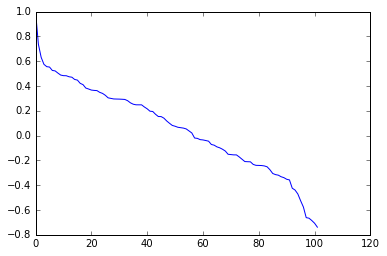

In [6]:
corr = df_features.corr()
corr1=corr.loc['target',:]

corr = corr.sort_values(by = 'target', ascending= False)
plt.plot(corr['target'].values, label="corr")
plt.show()

- Select only relevant features based on the pairwise correlarion

In [7]:
threshold_corr = 0.7
corr_significant = corr["target"].copy (deep =True)
corr_significant = corr_significant.loc[(corr_significant.values > threshold_corr) | \
                                       (corr_significant.values < -threshold_corr)]
print("Significant target variables are " + str(corr_significant.index[1:].values) )
print("Their correaltions are " + str( np.round(corr_significant[1:].values,2 ) ) )


Significant target variables are ['v_cont_55' 'v_cont_48' 'v_cont_49']
Their correaltions are [ 0.74 -0.71 -0.74]


# (2) Reduction techniques 

- Extract uncorrelated features from PCA

In [8]:
X = df_features.ix[:,1:]
Y = df_features["target"]
Num_components = 10
pca = PCA(n_components = Num_components)
pca.fit(X)
cum_variance_explained = pca.explained_variance_ratio_
print(np.round(pca.explained_variance_ratio_,2))
print("We explain " + str( np.round(pca.explained_variance_ratio_.sum(),2 ) ) )

[ 0.25  0.17  0.09  0.07  0.06  0.04  0.03  0.03  0.02  0.02]
We explain 0.78


- Save principal comoments for regression -we have only 10 regressors

In [9]:
PCA_scores = pca.fit_transform(X)

# (3) Multiple regregressions

In [10]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

### Naive OLS

In [11]:
Naive_OLS = linear_model.LinearRegression()
Naive_OLS.fit(X.values, Y.values)
in_sample_fit = Naive_OLS.predict(X)
R2.loc['In_Sample','Naive_OLS']=np.round(r2_score(Y.values, in_sample_fit),2);
print("R_squared for Naive OLS "  + str( np.round(r2_score(Y.values, in_sample_fit),2) ) )

R_squared for Naive OLS 0.7


### Run OLS for PCA scores


In [12]:
OLS = linear_model.LinearRegression()
OLS.fit(PCA_scores, Y)
in_sample_fit = OLS.predict(PCA_scores)
R2.loc['In_Sample','PCA']=np.round(r2_score(Y.values, in_sample_fit),2);
print('Coefficients:', OLS.coef_)
print("R_squared for PCA OLS "  + str( np.round(r2_score(Y.values, in_sample_fit),2) ) )
R2

('Coefficients:', array([-0.12581927, -0.06632266,  0.06312597,  0.07194161, -0.02411654,
        0.0225718 , -0.0853843 ,  0.13874386,  0.01237501, -0.05333591]))
R_squared for PCA OLS 0.64


,Naive_OLS,PCA,LASSO,Ridge,ElasticNet
In_Sample,0.7,0.64,0.0,0.0,0.0
Out_Sample,0.0,0.00,0.0,0.0,0.0


### Lasso

In [13]:
from sklearn import linear_model

#### Loop over alpha

In [14]:
LASSO = linear_model.Lasso(alpha = 0.1)
LASSO.fit(X, Y)
print("LASSO estimates \n")
print(LASSO.coef_)
print("Number of non-zero estimates is " + str( (1* LASSO.coef_ >0).sum() + (1* LASSO.coef_ <0).sum() ) )
print("R_squared for LASSO "+ str( np.round(LASSO.score(X,Y), 2) ) )

LASSO estimates 

[-0.         -0.00127588  0.         -0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.          0.         -0.
 -0.         -0.          0.         -0.          0.04180375  0.          0.
  0.          0.         -0.         -0.2777602   0.         -0.         -0.
 -0.         -0.          0.          0.18348013  0.          0.          0.
  0.         -0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.         -0.          0.02661469  0.         -0.          0.07809521
 -0.         -0.          0.         -0.18349572 -0.          0.          0.
  0.          0.          0.          0.         -0.          

### Ridge

In [15]:
Ridge = linear_model.Ridge(alpha = 0.05)
Ridge.fit(X, Y)
# print("Ridge estimates \n")
# print(Ridge.coef_)
print("R_squared for Ridge "+ str( np.round(Ridge.score(X,Y), 2) ) )

R_squared for Ridge 0.7


- Elastic net

In [16]:
Elastic_net = linear_model.ElasticNet(alpha = 0.05, l1_ratio = 1)
Elastic_net.fit(X, Y)
# print("Ridge estimates \n")
# print(Ridge.coef_)
print("R_squared for Elastic_net "+ str( np.round(Elastic_net.score(X,Y), 2) ) )

R_squared for Elastic_net 0.65


# (4) In sample performance

### Loop over alpha for each method

- Split data into in sample and out of sample

In [17]:
training_size = 1500
X_training = np.array(X[0:training_size:])
X_out_sample = np.array(X[training_size:])

Y_out_sample = np.array(Y[training_size:]) 
Y_training = np.array(Y[0:training_size:])

- Tune LASSO

In [18]:
alpha_loop = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
r_squared_loop = np.zeros(len(alpha_loop) )

for i in range(0, len(alpha_loop)): # Loop over alpha
    
    # Train for fied alpha
    LASSO = linear_model.Lasso(alpha = alpha_loop[i])
    LASSO.fit(X_training, Y_training)
    
    # Save loss function
    print(LASSO.score(X_training,Y_training))
    r_squared_loop[i] = LASSO.score(X_training,Y_training)
    
idx = np.argmax(r_squared_loop)
alpha_optimal_LASSO = alpha_loop[idx] 

# Run LASSO with chosen alpha
LASSO = linear_model.Lasso(alpha = alpha_optimal_LASSO)
LASSO.fit(X_training, Y_training)
R2.loc['In_Sample','LASSO']=np.round(LASSO.score(X_training,Y_training), 2) 
# print("LASSO estimates \n")
# print(LASSO.coef_)
print("Number of non-zero estimates is " + str( (1* LASSO.coef_ >0).sum() + (1* LASSO.coef_ <0).sum() ) )
print("R_squared for LASSO "+ str( np.round(LASSO.score(X_training,Y_training), 2) ) )



0.679124535117
0.658295250286
0.625582493416
0.571053605814
0.511391383206
0.433603253221
Number of non-zero estimates is 34
R_squared for LASSO 0.68


- Tune Ridge

In [19]:
alpha_loop = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
r_squared_loop = np.zeros(len(alpha_loop) )

for i in range(0, len(alpha_loop)): # Loop over alpha
    
    # Train for fied alpha
    Ridge = linear_model.Ridge(alpha = alpha_loop[i])
    Ridge.fit(X_training, Y_training)
    
    # Save loss function
    print(Ridge.score(X_training,Y_training))
    r_squared_loop[i] = Ridge.score(X_training,Y_training)
    
idx = np.argmax(r_squared_loop)
alpha_optimal_Ridge = alpha_loop[idx] 

# Run Ridge with chosen alpha
Ridge = linear_model.Ridge(alpha = alpha_optimal_Ridge)
Ridge.fit(X_training, Y_training)
R2.loc['In_Sample','Ridge']=np.round(Ridge.score(X_training,Y_training), 2) 
print("R_squared for Ridge "+ str( np.round(Ridge.score(X_training,Y_training), 2) ) )

0.706989153823
0.706987284613
0.706981946114
0.706963589187
0.706937971604
0.706907572561
R_squared for Ridge 0.71


- Tune Elastic net

In [20]:
alpha_loop = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
r_squared_loop = np.zeros(len(alpha_loop) )

for i in range(0, len(alpha_loop)): # Loop over alpha
    
    # Train for fied alpha
    ElasticNet = linear_model.ElasticNet(alpha = alpha_loop[i])
    ElasticNet.fit(X_training, Y_training)
    
    # Save loss function
    print(ElasticNet.score(X_training,Y_training))
    r_squared_loop[i] = ElasticNet.score(X_training,Y_training)
    
idx = np.argmax(r_squared_loop)
alpha_optimal_ElasticNet = alpha_loop[idx] 

# Run ElasticNet with chosen alpha
ElasticNet = linear_model.ElasticNet(alpha = alpha_optimal_ElasticNet)
ElasticNet.fit(X_training, Y_training)
R2.loc['In_Sample','ElasticNet']=np.round(ElasticNet.score(X_training,Y_training), 2) 
print("R_squared for Elastic Net is "+ str(  np.round(ElasticNet.score(X_training,Y_training), 2) ) )

0.68807949925
0.669484062095
0.65722286461
0.625723774364
0.59489894011
0.558597249305
R_squared for Elastic Net is 0.69


# (5) Out of sample performance 

- Naive PCA

In [21]:
Naive_OLS = linear_model.LinearRegression()
Naive_OLS.fit(X_training, Y_training)
out_sample_fit = Naive_OLS.predict(X_out_sample)
R2.loc['Out_Sample','Naive_OLS']=np.round(r2_score(Y_out_sample, out_sample_fit),2)
print("R_squared for Naive OLS "  + str( np.round(r2_score(Y_out_sample, out_sample_fit),2) ) )

R_squared for Naive OLS 0.63


- PCA OLS

In [22]:
OLS = linear_model.LinearRegression()
OLS.fit(PCA_scores[0:training_size,:], Y_training)
out_sample_fit = OLS.predict(PCA_scores[training_size:])
R2.loc['Out_Sample','PCA']=np.round(r2_score(Y_out_sample, out_sample_fit),2)
print("R_squared for PCA OLS "  + str( np.round(r2_score(Y_out_sample, out_sample_fit),2) ) )

R_squared for PCA OLS 0.62


- LASSO

In [23]:
# Run LASSO with chosen alpha
LASSO = linear_model.Lasso(alpha = alpha_optimal_LASSO)
LASSO.fit(X_training, Y_training)
R2.loc['Out_Sample','LASSO']= np.round(LASSO.score(X_out_sample,Y_out_sample), 2)
print("R_squared for LASSO "+ str( np.round(LASSO.score(X_out_sample,Y_out_sample), 2) ) )

R_squared for LASSO 0.64


- Ridge

In [24]:
# Run  Ridge with chosen alpha
Ridge = linear_model.Ridge(alpha = alpha_optimal_Ridge)
Ridge.fit(X_training, Y_training)
R2.loc['Out_Sample','Ridge']= np.round(Ridge.score(X_out_sample,Y_out_sample), 2)
print("R_squared for Ridge "+ str( np.round(Ridge.score(X_out_sample,Y_out_sample), 2) ) )

R_squared for Ridge 0.63


- Elasic Net

In [25]:
# Run Elastic Net with chosen alpha
ElasticNet = linear_model.ElasticNet(alpha = alpha_optimal_ElasticNet)
ElasticNet.fit(X_training, Y_training)
R2.loc['Out_Sample','ElasticNet']= np.round(ElasticNet.score(X_out_sample,Y_out_sample), 2)
print("R_squared for ElasticNet "+ str( np.round(ElasticNet.score(X_out_sample,Y_out_sample), 2) ) )
R2

R_squared for ElasticNet 0.63


,Naive_OLS,PCA,LASSO,Ridge,ElasticNet
In_Sample,0.70,0.64,0.68,0.71,0.69
Out_Sample,0.63,0.62,0.64,0.63,0.63
